# Handling Outliers and Basic Exploratory Analysis

***The main purpose of this project is to practice, and demonstrate knowledge of data cleaning, working with stakeholders to achieve a business objective, and data analytics***

## *Scope Overview*

1. Stakeholder wants to see trends in nighttime and daytime testing in respect to volume
2. Stakeholder wants to examine trends in subject and the amount of time used on the exam
3. Stakeholder is seeking recommendations in staffing for student-workers

## *Limitations of the Data*

*While the data covers multiple semesters, it is important to understand that this data is limited by several factors*

1. Summer 2019 was the first semester that the ODS portal was used but transitioning from an older system
2. COVID 19 - Half of the semester for Spring '20 was cancelled due to the pandemic; no exams for Summer '20; UA operated at reduced capacity for both Fall '20 and Spring '21 semesters
3. Online Exams are no longer being administered as of Fall 20 at ODS
4. Indicators (i.e., student, instructor, course number) that might reveal additional insights are protected information and cannot be used in the analysis

## *Dealing with the Limitations*

1. There might not be enough data to evaluate semester to semester data, but there is enough data to evaluate trends in week-to-week data, or evening vs. day time testing, which is an objective that our stakeholder has indicated. It is a matter of putting the data in the right context
2. The scripts used in this project can be used to load in new, more complete data as UA returns to full operations

## *Constraints*

1. '*actual_time*' values should not be zero. *Instances of this are most likely due to testing coordinator error when processing the exam in the portal*
2. '*actual_times*' that go over the '*allotted_time*' by more than 5% should be dropped. *It is likely that the testing coordinator forgot to check them out and since there is no way of knowing how long they actually took, the data can't be relied*
3. '*actual_times*' that exceeded the '*allotted_times*' but by not more than 5% should be replaced by the actual time. The '*actual_end*' should also relfect the correct time. *This is the stakeholder's preference. We are not concerned with the rate at which student's go over their allotted time, nor are concerned with process*
4. Outliers should be removed unless they can be verified
5. Night-Time testing is considered any exams that started after 16:45
6. Finals and regular semester exams should be seperated considering the massive difference in the two kinds of exams, their times, and their occurence
7. We should not include data from Spring 20 semester that resulted in an exam scheduled but cancelled due to covid

## *Notes*

When the allotted_time *cannot be verified*, it means that the instructor did not specifiy it in the ods portal. When we went to verify times for allotted_time outliers, we tried to either use the time specified on the agreement, impute with another exam in the same subject, infer based off a similiar subject, or we dropped the exam due to lack of information

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns

**Load in the dataframe**

*If you wish to add a csv file, use 'Indicators_remvoed_and_basic_analysis'. You should only be loading in one file at this point*

In [10]:
file = input('Enter the name of the file without the extension: ')
# finals_file = input('Enter the name of the finals semester without the extension: ')

Enter the name of the file without the extension: ods_072021


In [11]:
ods = pd.read_pickle(f'{file}.pkl')
# odsFinals = pd.read_pickle(f'{finals_file}.pkl')

**Add another column that displays the day of the week**

In [12]:
ods['name_of_day'] = ods['exam_date'].dt.day_name()
# odsFinals['name_of_day'] = odsFinals['exam_date'].dt.day_name()

## *Basic Summary Statistics and Outliers for Regular Semester Exams*

<AxesSubplot:>

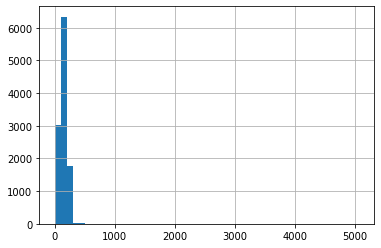

In [13]:
ods['allotted_time'].hist(bins=50)

*One obvious outlier we can get rid of is for 'allotted_time'. No student would have gotten over 3 and a half days to take an exam*

In [14]:
ods.loc[ods['allotted_time'] == 5070, ['subject', 'allotted_time', 'exam_date']]

,subject,allotted_time,exam_date
7064,ENGR,5070.0,2020-01-28
8212,ENGR,5070.0,2020-02-18
9229,ENGR,5070.0,2020-03-10
10201,ENGR,5070.0,2020-04-14
10343,ENGR,5070.0,2020-04-17


*What is the average amount of time these students got?*

In [15]:
ods.loc[(ods['subject'] == 'ENGR'), 'allotted_time'].mean()

304.5289855072464

*300 minutes is occassionally awarded in some finals, but we can see none of these dates align with final exam scheduling. We will drop these values*

**Drop the ENGR Exams with 5070 allotted time**

In [16]:
drop = ods.loc[ods['allotted_time']==5070].index
# drop = ods[ods['allotted_time']==5070].index
ods.drop(index=drop, inplace=True)

**Print out summary statistics**

count    11211.000000
mean       142.202034
std         64.322165
min          0.000000
25%        100.000000
50%        120.000000
75%        150.000000
max        750.000000
Name: allotted_time, dtype: float64


count    7679.000000
mean       86.379346
std        55.918497
min         0.000000
25%        48.000000
50%        76.000000
75%       112.000000
max       642.000000
Name: actual_time, dtype: float64


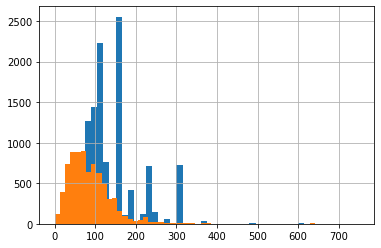

In [18]:
ods['allotted_time'].hist(bins=50)
ods['actual_time'].hist(bins=50)
print(ods['allotted_time'].describe())
print('\n')
print(ods['actual_time'].describe())

**Print out a 'box-and-whisker' plot to look at outliers**

<AxesSubplot:>

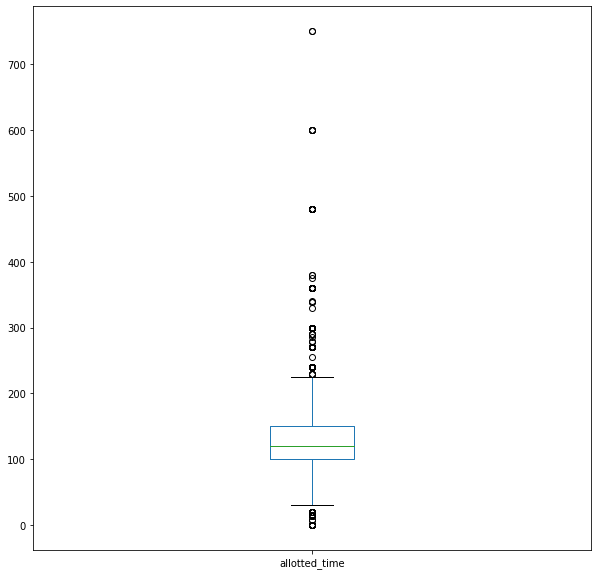

In [19]:
ods['allotted_time'].plot(kind='box', figsize=(10,10))

<AxesSubplot:>

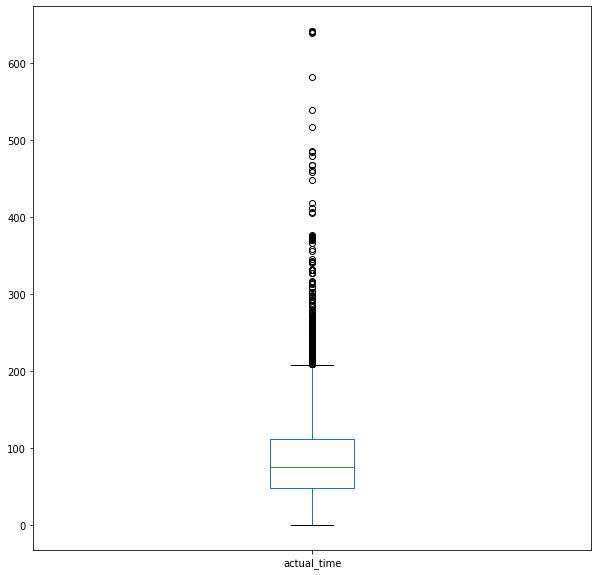

In [20]:
ods['actual_time'].plot(kind='box', figsize=(10,10))

**Handle the lower bound of outliers**

In [22]:
ods.loc[ods['allotted_time']< 30, ['allotted_time', 'actual_time', 'subject', 'section','no_show', 'exam_cancelled', 'exam_date',
                                   'extra_time_1.50x']]

,allotted_time,actual_time,subject,section,no_show,exam_cancelled,exam_date,extra_time_1.50x
1265,20.0,NaN,HY,28,True,False,2019-10-01,No
1376,15.0,30.0,HY,28,False,False,2019-10-02,Yes
1599,0.0,NaN,GBA,6,False,True,2019-10-08,Yes
1632,20.0,NaN,CD,1,False,True,2019-10-08,No
1755,0.0,NaN,GBA,21,False,True,2019-10-09,No
2044,20.0,NaN,CD,1,False,True,2019-10-15,No
2354,15.0,20.0,HY,28,False,False,2019-10-21,Yes
2414,20.0,22.0,HY,28,False,False,2019-10-22,No
3275,20.0,39.0,CD,1,False,False,2019-11-07,No
3279,0.0,32.0,EC,4,False,False,2019-11-07,Yes


*Short quizzes that are no more than 20 mins are common. These are left in the dataframe*

*Research from the ODS Portal to find missing times and fill in values*

For Exams that have 0.0 allotted time and have null actual time values:
1. GBA exams with no time allotted and null were either incorrectly scheduled by the student, and cancelled by staff or rescheduled for another time
2. CJ exams were given online and allowed the entire day to take the exam; they did not test at ODS
3. AEM exam was cancelled
4. HES exam was cancelled
5. FI 321 exam was cancelled

*I am not sure why the system recorded the exam as zero allotted time in these instances, where it still lists the allotted time in other cancelled exams. My theory is that the exams were cancelled before they could've been approved by ODS staff. We will drop these from the dataframe*

In [23]:
ods.drop(index=ods[(ods['allotted_time'] == 0.0) & (ods['actual_time'].isna())].index, inplace=True)

**Run the code again to see what else we need to do**

In [24]:
ods.loc[ods['allotted_time']< 30, ['allotted_time', 'actual_time', 'subject', 'section','no_show', 'exam_cancelled', 'exam_date',
                                   'extra_time_1.50x']]

,allotted_time,actual_time,subject,section,no_show,exam_cancelled,exam_date,extra_time_1.50x
1265,20.0,NaN,HY,28,True,False,2019-10-01,No
1376,15.0,30.0,HY,28,False,False,2019-10-02,Yes
1632,20.0,NaN,CD,1,False,True,2019-10-08,No
2044,20.0,NaN,CD,1,False,True,2019-10-15,No
2354,15.0,20.0,HY,28,False,False,2019-10-21,Yes
2414,20.0,22.0,HY,28,False,False,2019-10-22,No
3275,20.0,39.0,CD,1,False,False,2019-11-07,No
3279,0.0,32.0,EC,4,False,False,2019-11-07,Yes
3365,15.0,21.0,HY,28,False,False,2019-11-08,Yes
4155,15.0,NaN,HY,28,True,False,2019-11-22,Yes


*Now, we can fill in the '0.0' for allotted times where an actual time was recorded for that subject on the same day. We need to research the portal to do this*

**Drop rows that have no values to reference**

*7237 has no reference in the portal, so we can drop that record*

In [25]:
ods.drop(index=7237,inplace=True)

**Fill in the missing allotted time for EC with 113**

In [26]:
ods.loc[3279, ['allotted_time']]=113.0
ods.loc[4172, ['allotted_time']]=360.0
ods.loc[7229, ['allotted_time']]=75.0
ods.loc[8854, ['allotted_time']]=120.0

*Where are we at now?*

In [27]:
ods.loc[ods['allotted_time']< 30, ['allotted_time', 'actual_time', 'subject', 'section','no_show', 'exam_cancelled', 'exam_date',
                                   'extra_time_1.50x']]

,allotted_time,actual_time,subject,section,no_show,exam_cancelled,exam_date,extra_time_1.50x
1265,20.0,NaN,HY,28,True,False,2019-10-01,No
1376,15.0,30.0,HY,28,False,False,2019-10-02,Yes
1632,20.0,NaN,CD,1,False,True,2019-10-08,No
2044,20.0,NaN,CD,1,False,True,2019-10-15,No
2354,15.0,20.0,HY,28,False,False,2019-10-21,Yes
2414,20.0,22.0,HY,28,False,False,2019-10-22,No
3275,20.0,39.0,CD,1,False,False,2019-11-07,No
3365,15.0,21.0,HY,28,False,False,2019-11-08,Yes
4155,15.0,NaN,HY,28,True,False,2019-11-22,Yes
4296,20.0,NaN,CD,1,True,False,2019-11-26,No


## Drop Exams after 03/13/2020, but before 09/01/2020

*These exams were scheduled before covid but never took place*

In [32]:
ods.loc[(ods['exam_date'] > '2020-03-13') & (ods['exam_date']< '2020-09-01')]

,subject,section,exam_date,proctor,room_number,start_time,end_time,actual_start,actual_end,first_entered,...,extra_time_2.00x,makeup_accommodation,noScantronExam,readerForExams,allotted_time,actual_time,exam_cancelled,no_show,days_requested_submitted_in_advance,name_of_day
9551,BSC,4,2020-03-23,Unspecified,04,15:30:00,18:53:00,15:30:00,18:53:00,2020-01-13 11:39:00,...,No,No,No,No,203.0,NaN,True,False,70.0,Monday
9552,CJ,900,2020-03-23,Unspecified,Scribe,17:30:00,19:30:00,17:30:00,19:30:00,2020-01-15 11:21:00,...,Yes,No,Yes,Yes,120.0,NaN,True,False,68.0,Monday
9553,MTE,998,2020-03-23,Unspecified,02,17:30:00,19:45:00,17:30:00,19:45:00,2020-01-16 21:24:00,...,No,No,No,No,135.0,NaN,True,False,67.0,Monday
9554,BSC,920,2020-03-24,Unspecified,03,10:00:00,12:15:00,10:00:00,12:15:00,2020-02-07 12:22:00,...,No,No,No,No,135.0,NaN,True,False,46.0,Tuesday
9555,ECE,1,2020-03-24,Unspecified,06,11:00:00,13:30:00,11:00:00,13:30:00,2020-01-17 10:25:00,...,Yes,No,No,No,150.0,NaN,True,False,67.0,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11235,PSC,1,2020-05-01,Unspecified,04,11:30:00,15:15:00,11:30:00,15:15:00,2020-01-08 13:25:00,...,No,No,No,No,225.0,NaN,True,False,114.0,Friday
11236,AEM,3,2020-05-01,Unspecified,03,12:00:00,16:30:00,12:00:00,16:30:00,2020-01-26 14:04:00,...,No,Yes,No,No,270.0,NaN,True,False,96.0,Friday
11237,MC,1,2020-05-05,Unspecified,01,12:30:00,14:23:00,12:30:00,14:23:00,2020-02-29 23:12:00,...,No,No,Yes,No,113.0,NaN,True,False,66.0,Tuesday
11238,ECE,2,2020-05-06,Unspecified,01,12:00:00,13:40:00,12:00:00,13:40:00,2020-03-02 18:11:00,...,Yes,No,No,No,100.0,NaN,True,False,65.0,Wednesday


In [34]:
idx = ods.loc[(ods['exam_date'] > '2020-03-13') & (ods['exam_date']< '2020-09-01')].index

In [35]:
ods.drop(index=idx, inplace=True)

*We have exams that were not cancelled nor a no-show. I've looked into this and my best theory is that the exams in these cases were cancelled before they could've been approved. They should not be included*

In [38]:
ods[ods['actual_time']==0.0]

,subject,section,exam_date,proctor,room_number,start_time,end_time,actual_start,actual_end,first_entered,...,extra_time_2.00x,makeup_accommodation,noScantronExam,readerForExams,allotted_time,actual_time,exam_cancelled,no_show,days_requested_submitted_in_advance,name_of_day
376,CD,1,2019-09-17,Bulls,42,13:00:00,14:53:00,13:29:00,13:29:00,2019-09-10 13:12:00,...,No,No,No,No,113.0,0.0,False,False,7.0,Tuesday
710,EN,4,2019-09-23,Bulls,45,12:00:00,13:15:00,13:03:00,13:03:00,2019-09-09 14:01:00,...,No,No,No,No,75.0,0.0,False,False,14.0,Monday
1001,LGS,336,2019-09-25,Unspecified,Not Specified,18:30:00,20:23:00,17:54:00,17:54:00,2019-09-25 17:53:00,...,No,No,No,No,113.0,0.0,False,False,0.0,Wednesday
1274,PY,10,2019-10-01,Vanslambrouck,48,14:00:00,15:53:00,14:42:00,14:42:00,2019-09-01 15:52:00,...,No,No,No,No,113.0,0.0,False,False,30.0,Tuesday
1277,RHM,1,2019-10-01,Vanslambrouck,14,14:00:00,15:40:00,14:20:00,14:20:00,2019-09-05 17:18:00,...,Yes,No,No,No,100.0,0.0,False,False,26.0,Tuesday
1630,MKT,5,2019-10-08,Bulls,13,14:00:00,15:53:00,14:37:00,14:37:00,2019-09-10 11:23:00,...,No,No,No,No,113.0,0.0,False,False,28.0,Tuesday
1720,PY,2,2019-10-09,Bulls,48,10:00:00,11:40:00,11:02:00,11:02:00,2019-09-04 14:29:00,...,Yes,Yes,No,No,100.0,0.0,False,False,35.0,Wednesday
1817,KIN,1,2019-10-10,Bulls,Scribe,11:00:00,12:53:00,13:30:00,13:30:00,2019-10-04 11:11:00,...,No,No,Yes,No,113.0,0.0,False,False,6.0,Thursday
2060,EC,1,2019-10-15,Vanslambrouck,03,16:00:00,17:53:00,16:28:00,16:28:00,2019-09-05 13:50:00,...,No,No,No,No,113.0,0.0,False,False,40.0,Tuesday
2125,RHM,2,2019-10-16,Bulls,07,11:00:00,12:15:00,11:24:00,11:24:00,2019-10-14 11:59:00,...,No,No,No,No,75.0,0.0,False,False,2.0,Wednesday


In [39]:
index = ods[ods['actual_time']==0.0].index

ods.drop(index=index, inplace=True)

## Double Checking DataFrames before Exporting

In [40]:
ods.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9508 entries, 0 to 9550
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   subject                              9508 non-null   object        
 1   section                              9508 non-null   int64         
 2   exam_date                            9508 non-null   datetime64[ns]
 3   proctor                              9508 non-null   object        
 4   room_number                          9508 non-null   string        
 5   start_time                           9508 non-null   object        
 6   end_time                             9508 non-null   object        
 7   actual_start                         9508 non-null   object        
 8   actual_end                           9508 non-null   object        
 9   first_entered                        9508 non-null   datetime64[ns]
 10  fileUploaded

*We have a null at 4172*

**Drop the null value at index 4172**

In [40]:
ods.drop(index=4172, inplace=True)

In [41]:
ods.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7357 entries, 0 to 9550
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   subject                              7357 non-null   object        
 1   section                              7357 non-null   float64       
 2   exam_date                            7357 non-null   datetime64[ns]
 3   proctor                              7357 non-null   object        
 4   room_number                          7357 non-null   string        
 5   start_time                           7357 non-null   object        
 6   end_time                             7357 non-null   object        
 7   actual_start                         7357 non-null   object        
 8   actual_end                           7357 non-null   object        
 9   first_entered                        7357 non-null   datetime64[ns]
 10  fileUploaded

In [45]:
odsFinals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1290 entries, 1 to 6467
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   subject                              1290 non-null   object        
 1   section                              1290 non-null   int64         
 2   exam_date                            1290 non-null   datetime64[ns]
 3   proctor                              1290 non-null   object        
 4   room_number                          1290 non-null   string        
 5   start_time                           1290 non-null   object        
 6   end_time                             1290 non-null   object        
 7   actual_start                         1290 non-null   object        
 8   actual_end                           1290 non-null   object        
 9   first_entered                        1290 non-null   datetime64[ns]
 10  fileUploaded

## Exporting for PostgreSQL and Pickle

In [44]:
ods.to_csv('PostgrExReg071021.csv')
odsFinals.to_csv('PostgrExFinals071021.csv')
ods.to_pickle('pickled_cleaned_reg_exams.pkl')
odsFinals.to_pickle('pickled_cleaned_finals_exams.pkl')